## Notebook to preprocess all external data for each SA2 region
* Make sure to run datascrape.ipynb before running

In [126]:
import pandas as pd
import geopandas as gpd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import random 
from statsmodels.tsa.stattools import adfuller

In [60]:
## Population Data
## Population Projection Data:\n",
population_projection = pd.read_csv("../data/landing/yearly_pop_projection_perSA.csv")

In [61]:
# Filter for 'Persons' so we only get the total population for each region\,
df_persons = population_projection[population_projection['SEX'] == 'Persons']

# Pivot the DataFrame to get `SA2_NAME` as rows, `YEAR` as columns, and `Total` as values\n
df_pivot = df_persons.pivot_table(index='SA2_NAME', columns='YEAR', values='Total', aggfunc='sum')

# View the result
df_pivot.head()

YEAR,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032
SA2_NAME,,,,,,,,,,,,,,,,
Abbotsford,9450,10112,10779,11438,12083,12714,13327,13929,14513,15082,15634,16180,16720,17252,17777,18291
Airport West,8034,8145,8262,8378,8491,8605,8715,8825,8935,9041,9147,9255,9363,9470,9576,9680
Albert Park,16735,16979,17239,17499,17754,18000,18234,18449,18652,18839,19009,19179,19350,19518,19688,19854
Alexandra,6534,6589,6643,6694,6737,6779,6816,6850,6882,6907,6925,6940,6954,6963,6967,6969
Alfredton,12525,13166,13813,14454,15073,15688,16294,16896,17489,18056,18611,19166,19716,20262,20805,21343


In [2]:
# Read the GeoPackage
population_gdf = gpd.read_file("../data/population/population_extracted/32180_ERP_2023_SA2_GDA2020.gpkg")


In [3]:
# extract SA2 name and ERP (estimated residential population) for victoria only

population_gdf = population_gdf[population_gdf['State_name_2021'] == 'Victoria']

population_gdf = population_gdf[[ 'SA2_name_2021',
 'ERP_2006',
 'ERP_2007',
 'ERP_2008',
 'ERP_2009',
 'ERP_2010',
 'ERP_2011',
 'ERP_2012',
 'ERP_2013',
 'ERP_2014',
 'ERP_2015',
 'ERP_2016',
 'ERP_2017',
 'ERP_2018',
 'ERP_2019',
 'ERP_2020',
 'ERP_2021',
 'ERP_2022',
 'ERP_2023']]

In [4]:
population_df = pd.DataFrame(population_gdf).set_index('SA2_name_2021')
population_df.columns = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [5]:
population_df

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
SA2_name_2021,,,,,,,,,,,,,,,,,,
Alfredton,6761.0,7034.0,7272.0,7614.0,7894.0,8452.0,9060.0,9714.0,10338.0,11039.0,11852,12649,13537,14434,15507,16841,18002,18997
Ballarat,12356.0,12408.0,12480.0,12476.0,12462.0,12365.0,12357.0,12352.0,12327.0,12300.0,12301,12266,12244,12320,12196,12071,11938,11809
Buninyong,6037.0,6131.0,6252.0,6431.0,6595.0,6725.0,6854.0,6984.0,7082.0,7191.0,7311,7409,7418,7458,7377,7229,7247,7323
Delacombe,5041.0,5206.0,5349.0,5557.0,5699.0,5838.0,6020.0,6267.0,6583.0,6846.0,7195,7622,8183,8890,9755,10648,11798,12869
Smythes Creek,3542.0,3594.0,3658.0,3714.0,3774.0,3819.0,3872.0,3914.0,3945.0,3966.0,3990,4004,4042,4112,4152,4211,4223,4268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Otway,3459.0,3489.0,3501.0,3490.0,3460.0,3420.0,3456.0,3497.0,3519.0,3538.0,3556,3635,3710,3802,3911,3979,3974,3983
Moyne - East,6652.0,6606.0,6631.0,6703.0,6739.0,6779.0,6764.0,6749.0,6734.0,6716.0,6709,6717,6746,6798,6883,6990,7046,7132
Moyne - West,8601.0,8694.0,8792.0,8878.0,8965.0,9024.0,9167.0,9300.0,9383.0,9467.0,9603,9686,9783,9845,9859,9967,10098,10148


In [7]:
## Homelessness

In [6]:
# must conda/pip install openpyxl

homelessness_df_21 = pd.read_excel('../data/homelessness/homelessness21.xlsx', sheet_name='Table_5.3')

In [7]:
homelessness_df_21 = homelessness_df_21.loc[775:1375]
homelessness_df_21 = homelessness_df_21[pd.notna(homelessness_df_21['Unnamed: 3'])]
homelessness_df_21 = homelessness_df_21.iloc[:, -2:]
homelessness_df_21.columns = ['SA2_name_2021', 'all_homeless_persons_2021']

In [8]:
homelessness_df_21

,SA2_name_2021,all_homeless_persons_2021
775,Buninyong,43
776,Delacombe,43
777,Smythes Creek,5
778,Wendouree - Miners Rest,93
779,Ballarat East - Warrenheip,148
...,...,...
1370,Otway,27
1372,Moyne - East,25
1373,Moyne - West,6
1374,Warrnambool - North,95


In [9]:
# must conda/pip install openpyxl

homelessness_df_16 = pd.read_excel('../data/homelessness/homelessness16.xlsx', sheet_name='Table_5.3')

In [10]:
homelessness_df_16 = homelessness_df_16.loc[707:1249]
homelessness_df_16 = homelessness_df_16[pd.notna(homelessness_df_16['Unnamed: 3'])]
homelessness_df_16 = homelessness_df_16.iloc[:, -2:]
homelessness_df_16.columns = ['SA2_name_2021', 'all_homeless_persons_2016']

In [11]:
homelessness_df_16

,SA2_name_2021,all_homeless_persons_2016
707,Alfredton,3
708,Ballarat,123
709,Ballarat - North,92
710,Ballarat - South,74
711,Buninyong,0
...,...,...
1244,Otway,3
1246,Moyne - East,6
1247,Moyne - West,16
1248,Warrnambool - North,87


In [12]:
# must conda/pip install openpyxl

homelessness_df_11 = pd.read_excel('../data/homelessness/homelessness11.xlsx', sheet_name='Table_1')

In [13]:
homelessness_df_11 = homelessness_df_11.loc[668:1180]
homelessness_df_11 = homelessness_df_11[pd.notna(homelessness_df_11['Unnamed: 3'])]
homelessness_df_11 = homelessness_df_11.iloc[:, -2:]
homelessness_df_11.columns = ['SA2_name_2021', 'all_homeless_persons_2011']

In [14]:
homelessness_df_11

,SA2_name_2021,all_homeless_persons_2011
668,Alfredton,10
669,Ballarat,97
670,Ballarat - North,84
671,Ballarat - South,128
672,Buninyong,3
...,...,...
1176,Moyne - East,0
1177,Moyne - West,3
1178,Otway,9
1179,Warrnambool - North,74


In [15]:
homelessness_df = homelessness_df_11.merge(homelessness_df_16, on='SA2_name_2021').merge(homelessness_df_21, on='SA2_name_2021')
homelessness_df = homelessness_df.set_index('SA2_name_2021')
homelessness_df.columns = [2011,2016,2021]
homelessness_df

,2011,2016,2021
SA2_name_2021,,,
Buninyong,3,0,43
Delacombe,33,38,43
Smythes Creek,0,0,5
Wendouree - Miners Rest,51,74,93
Creswick - Clunes,17,4,15
...,...,...,...
Moyne - East,0,6,25
Moyne - West,3,16,6
Otway,9,3,27


In [18]:
# socioeconomic

In [65]:
# must conda/pip install openpyxl

socioeconomic_df_21 = pd.read_excel('../data/socioeconomic/socioeconomic21.xlsx', sheet_name='Table 1')

In [66]:
socioeconomic_df_21 = socioeconomic_df_21.loc[634:1149]
socioeconomic_df_21 = socioeconomic_df_21.iloc[:, [1, 4]]
socioeconomic_df_21.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2021']

In [67]:
socioeconomic_df_21

,SA2_name_2021,Index of Relative Socio-economic Advantage and Disadvantage 2021
634,Alfredton,1011
635,Ballarat,1040
636,Buninyong,1040
637,Delacombe,947
638,Smythes Creek,1005
...,...,...
1145,Otway,977
1146,Moyne - East,986
1147,Moyne - West,1005
1148,Warrnambool - North,956


In [68]:
# must conda/pip install xlrd

socioeconomic_df_16 = pd.read_excel('../data/socioeconomic/socioeconomic16.xlsx', sheet_name='Table 1')

In [69]:
socioeconomic_df_16 = socioeconomic_df_16.loc[565:1019]
socioeconomic_df_16 = socioeconomic_df_16.iloc[:, [1, 4]]
socioeconomic_df_16.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2016']

In [70]:
socioeconomic_df_16

,SA2_name_2021,Index of Relative Socio-economic Advantage and Disadvantage 2016
565,Alfredton,1025
566,Ballarat,1037
567,Ballarat - North,983
568,Ballarat - South,912
569,Buninyong,1051
...,...,...
1015,Otway,976
1016,Moyne - East,995
1017,Moyne - West,998
1018,Warrnambool - North,958


In [71]:
# must conda/pip install xlrd

socioeconomic_df_11 = pd.read_excel('../data/socioeconomic/socioeconomic11.xlsx', sheet_name='Table 2')

In [72]:
socioeconomic_df_11 = socioeconomic_df_11.loc[1459:1882]
socioeconomic_df_11 = socioeconomic_df_11.iloc[:, [1, 3]]
socioeconomic_df_11.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2011']

In [73]:
socioeconomic_df_11

,SA2_name_2021,Index of Relative Socio-economic Advantage and Disadvantage 2011
1459,Alfredton,1036.118125
1460,Ballarat,1023.752255
1461,Ballarat - North,982.705859
1462,Ballarat - South,924.379674
1463,Buninyong,1064.12227
...,...,...
1878,Moyne - East,999.233
1879,Moyne - West,1007.253286
1880,Otway,976.754857
1881,Warrnambool - North,965.073742


In [97]:
socioeconomic_df = socioeconomic_df_11.merge(socioeconomic_df_16, on='SA2_name_2021').merge(socioeconomic_df_21, on='SA2_name_2021')

In [102]:
socioeconomic_df.head()
socioeconomic_df.rename(columns={
    'Index of Relative Socio-economic Advantage and Disadvantage 2011': '2011',
    'Index of Relative Socio-economic Advantage and Disadvantage 2016': '2016',
    'Index of Relative Socio-economic Advantage and Disadvantage 2021': '2021'
}, inplace=True)
socioeconomic_df.head()

,2011,2016,2021
SA2_name_2021,,,
Alfredton,1036.118125,1025,1011
Ballarat,1023.752255,1037,1040
Buninyong,1064.12227,1051,1040
Delacombe,947.363463,940,947
Smythes Creek,1022.078563,1012,1005


## TESTING PROJECTIONS

In [128]:
# Example DataFrame transposition
df_transposed = socioeconomic_df.transpose()

# Reindex to include all complete years
complete_years = list(range(2011, 2022))  # Example range
df_transposed = df_transposed.reindex(complete_years)

# Convert all values to numeric, excluding the first row if it's still being treated as part of the data
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')

# Use spline interpolation
df_transposed.interpolate(method='spline', order=2, inplace=True)

# Verify the result
df_transposed.head(11)

SA2_name_2021,Alfredton,Ballarat,Buninyong,Delacombe,Smythes Creek,Wendouree - Miners Rest,Creswick - Clunes,Daylesford,Gordon (Vic.),Avoca,...,Southern Grampians,Camperdown,Colac,Corangamite - North,Corangamite - South,Moyne - East,Moyne - West,Otway,Warrnambool - North,Warrnambool - South
2011,1036.118125,1023.752255,1064.122270,947.363463,1022.078563,898.897977,955.024591,982.907723,1000.323789,920.910544,...,1006.263745,927.015504,916.147267,959.351998,998.767806,999.23300,1007.253286,976.754857,965.073742,978.659579
2012,1034.125050,1027.221623,1061.328034,944.741693,1019.816566,896.006544,957.177705,985.013560,1000.153128,921.535592,...,1006.669896,927.651163,914.266032,956.533438,994.672820,998.76776,1004.102366,976.463497,963.253095,974.634897
2013,1032.016700,1030.281082,1058.618690,942.694462,1017.677710,893.471029,958.851803,987.275707,1000.035419,921.957061,...,1006.646598,928.167442,912.510688,953.888959,991.048547,998.11184,1001.601578,976.242331,961.635396,971.356598
2014,1029.793075,1032.930631,1055.994236,941.221770,1015.661998,891.291434,960.046885,989.694162,999.970661,922.174952,...,1006.193849,928.564341,910.881235,951.418559,987.894986,997.26524,999.750920,976.091360,960.220648,968.824682
2015,1027.454175,1035.170271,1053.454672,940.323616,1013.769428,889.467757,960.762951,992.268927,999.958855,922.189265,...,1005.311649,928.841861,909.377672,949.122240,985.212137,996.22796,998.550394,976.010583,959.008849,967.039149
2016,1025.000000,1037.000000,1051.000000,940.000000,1012.000000,888.000000,961.000000,995.000000,1000.000000,922.000000,...,1004.000000,929.000000,908.000000,947.000000,983.000000,995.00000,998.000000,976.000000,958.000000,966.000000
2017,1022.430550,1038.419820,1048.630218,940.250923,1010.353715,886.888162,960.758033,997.887382,1000.094097,921.607156,...,1002.258900,929.038760,906.748219,945.051840,981.258576,993.58136,998.099737,976.059611,957.194101,965.707234
2018,1019.745825,1039.429729,1046.345328,941.076384,1008.830572,886.132243,960.037049,1000.931073,1000.241145,921.010735,...,1000.088351,928.958139,905.622328,943.277760,979.987863,991.97204,998.849606,976.189417,956.591151,966.160851
2019,1016.945825,1040.029729,1044.145328,942.476384,1007.430572,885.732243,958.837049,1004.131073,1000.441145,920.210735,...,997.488351,928.758139,904.622328,941.677760,979.187863,990.17204,1000.249606,976.389417,956.191151,967.360851
2020,1014.030550,1040.219820,1042.030218,944.450923,1006.153715,885.688162,957.158033,1007.487382,1000.694097,919.207156,...,994.458900,928.438760,903.748219,940.251840,978.858576,988.18136,1002.299737,976.659611,955.994101,969.307234


first we interpolate

In [116]:
# # Example DataFrame transposition
# df_transposed = socioeconomic_df.transpose()

# # Reindex to include all complete years
# complete_years = list(range(2011, 2022))  # Example range
# df_transposed = df_transposed.reindex(complete_years)

# # Convert all values to numeric, excluding the first row if it's still being treated as part of the data
# df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')

# # Interpolate missing years (linear interpolation)
# df_transposed.interpolate(method='linear', inplace=True)

# # Verify the result
# df_transposed.head(11)

SA2_name_2021,Alfredton,Ballarat,Buninyong,Delacombe,Smythes Creek,Wendouree - Miners Rest,Creswick - Clunes,Daylesford,Gordon (Vic.),Avoca,...,Southern Grampians,Camperdown,Colac,Corangamite - North,Corangamite - South,Moyne - East,Moyne - West,Otway,Warrnambool - North,Warrnambool - South
2011,1036.118125,1023.752255,1064.122270,947.363463,1022.078563,898.897977,955.024591,982.907723,1000.323789,920.910544,...,1006.263745,927.015504,916.147267,959.351998,998.767806,999.2330,1007.253286,976.754857,965.073742,978.659579
2012,1033.894500,1026.401804,1061.497816,945.890770,1020.062851,896.718382,956.219672,985.326178,1000.259031,921.128435,...,1005.810996,927.412403,914.517814,956.881598,995.614245,998.3864,1005.402629,976.603885,963.658994,976.127663
2013,1031.670875,1029.051353,1058.873362,944.418078,1018.047138,894.538786,957.414754,987.744634,1000.194273,921.346326,...,1005.358247,927.809303,912.888360,954.411199,992.460683,997.5398,1003.551972,976.452914,962.244245,973.595747
2014,1029.447250,1031.700902,1056.248908,942.945385,1016.031425,892.359191,958.609836,990.163089,1000.129515,921.564218,...,1004.905498,928.206202,911.258907,951.940799,989.307122,996.6932,1001.701315,976.301943,960.829497,971.063832
2015,1027.223625,1034.350451,1053.624454,941.472693,1014.015713,890.179595,959.804918,992.581545,1000.064758,921.782109,...,1004.452749,928.603101,909.629453,949.470399,986.153561,995.8466,999.850657,976.150971,959.414748,968.531916
2016,1025.000000,1037.000000,1051.000000,940.000000,1012.000000,888.000000,961.000000,995.000000,1000.000000,922.000000,...,1004.000000,929.000000,908.000000,947.000000,983.000000,995.0000,998.000000,976.000000,958.000000,966.000000
2017,1022.200000,1037.600000,1048.800000,941.400000,1010.600000,887.600000,959.800000,998.200000,1000.200000,921.200000,...,1001.400000,928.800000,907.000000,945.400000,982.200000,993.2000,999.400000,976.200000,957.600000,967.200000
2018,1019.400000,1038.200000,1046.600000,942.800000,1009.200000,887.200000,958.600000,1001.400000,1000.400000,920.400000,...,998.800000,928.600000,906.000000,943.800000,981.400000,991.4000,1000.800000,976.400000,957.200000,968.400000
2019,1016.600000,1038.800000,1044.400000,944.200000,1007.800000,886.800000,957.400000,1004.600000,1000.600000,919.600000,...,996.200000,928.400000,905.000000,942.200000,980.600000,989.6000,1002.200000,976.600000,956.800000,969.600000
2020,1013.800000,1039.400000,1042.200000,945.600000,1006.400000,886.400000,956.200000,1007.800000,1000.800000,918.800000,...,993.600000,928.200000,904.000000,940.600000,979.800000,987.8000,1003.600000,976.800000,956.400000,970.800000


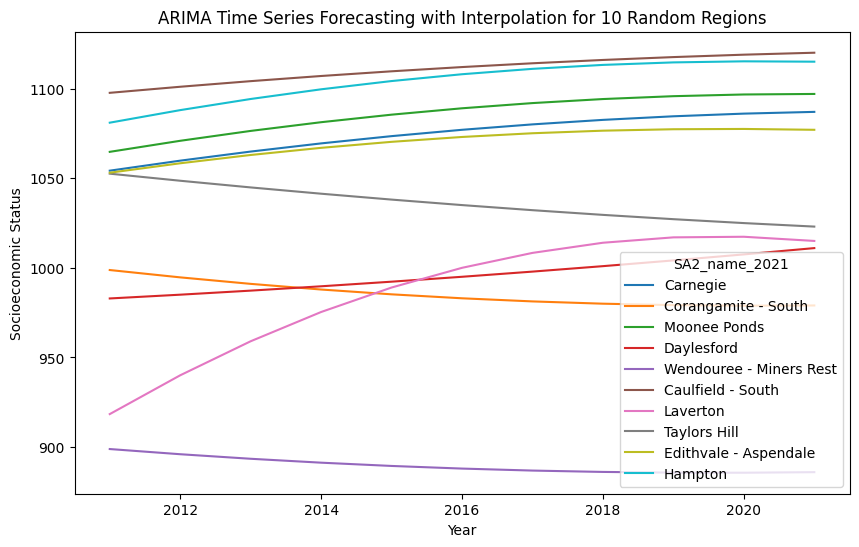

In [129]:
# GRAPH INTERPOLATIONS:

# Randomly select 10 regions to plot
random_regions = random.sample(df_transposed.columns.tolist(), 10)

# Plot the results for the 10 random regions
df_transposed[random_regions].plot(figsize=(10, 6))
plt.title('ARIMA Time Series Forecasting with Interpolation for 10 Random Regions')
plt.xlabel('Year')
plt.ylabel('Socioeconomic Status')
plt.show()


next we extrapolate

In [30]:
## inflation

In [31]:
# lets extract housing CPI index, as well as overall CPI with housing removed as a measure of all other inflation
# this will be best for analysis to keep both variables as independent as possible

In [27]:
housing_cpi_df = pd.read_excel('../data/inflation/inflation.xlsx', sheet_name='Data1')

In [28]:
excluding_housing_cpi_df = pd.read_excel('../data/inflation/inflation.xlsx', sheet_name='Data2')

In [29]:
housing_cpi_df = housing_cpi_df[['Unnamed: 0','Index Numbers ;  Housing ;  Melbourne ;']]

In [30]:
excluding_housing_cpi_df = excluding_housing_cpi_df[['Unnamed: 0','Index Numbers ;  All groups CPI excluding Housing ;  Melbourne ;']]

In [31]:
housing_cpi_df = housing_cpi_df.rename(columns={'Unnamed: 0': "quarter"})

In [32]:
inflation_df = pd.concat([housing_cpi_df,excluding_housing_cpi_df],axis=1).drop('Unnamed: 0', axis=1).dropna().iloc[9:].rename(columns={'Index Numbers ;  Housing ;  Melbourne ;': "housing_index", 'Index Numbers ;  All groups CPI excluding Housing ;  Melbourne ;': 'CPI_without_housing'})

In [33]:
inflation_df['Year'] = pd.to_datetime(inflation_df['quarter']).dt.year

In [34]:
# take average across each year
yearly_avg = inflation_df.groupby('Year')[['housing_index', 'CPI_without_housing']].mean()

# Transpose the DataFrame so that 'Year' becomes the columns, and we have rows for housing_index and CPI_without_housing
new_inflation_df = yearly_avg.T.loc[:, 2006:2024]

In [35]:
new_inflation_df

Year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
housing_index,76.4,78.8,83.775,88.075,94.175,98.75,101.625,106.825,109.35,112.275,115.025,119.4,123.95,124.4,125.8,125.575,136.4,145.775,149.75
CPI_without_housing,88.8,90.775,94.125,94.6,96.55,99.525,100.775,102.475,104.9,105.95,107.2,109.15,111.125,113.2,114.675,118.225,125.175,131.175,134.55


In [41]:
# lets look at population distributions

In [36]:
pop_dist_df = pd.read_excel('../data/population_dist/population_dist.xlsx', sheet_name='Table 1')

In [37]:
pop_dist_df = pop_dist_df.loc[9879:14576]
pop_dist_df = pop_dist_df.iloc[:, [1, 2, 4, 9, 127, 131, 142, 156]]
pop_dist_df.columns = ['SA2_name_2021', 'Year', 'Population Density', 'Median Age', 'Overseas Arrivals', 'Percentage Aboriginal and Torres Straight Islander', 'Percentage Overseas Born', 'Percentage Australian Citizen']
# population density in persons/km^2

In [38]:
pop_dist_df

,SA2_name_2021,Year,Population Density,Median Age,Overseas Arrivals,Percentage Aboriginal and Torres Straight Islander,Percentage Overseas Born,Percentage Australian Citizen
9879,Alfredton,2011,-,-,-,0.8,-,3.9
9880,Alfredton,2016,-,-,-,0.8,12.3,4.8
9881,Alfredton,2017,-,-,-,-,-,-
9882,Alfredton,2018,256.8,33.1,-,-,-,-
9883,Alfredton,2019,273.8,33,-,-,-,-
...,...,...,...,...,...,...,...,...
14572,Warrnambool - South,2019,110.4,42.3,-,-,-,-
14573,Warrnambool - South,2020,111,43.1,-,-,-,-
14574,Warrnambool - South,2021,110.6,44.2,-,1.8,10.8,5.5
14575,Warrnambool - South,2022,110.8,44.6,191,-,-,-


In [39]:
population_density_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Population Density')
median_age_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Median Age')
overseas_arrivals_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Overseas Arrivals')
percentage_aboriginal_torres_straight_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Aboriginal and Torres Straight Islander')
percentage_overseas_born_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Overseas Born')
percentage_australian_citizen_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Australian Citizen')

In [40]:
percentage_australian_citizen_df

Year,2011,2016,2017,2018,2019,2020,2021,2022,2023
SA2_name_2021,,,,,,,,,
Abbotsford,11.8,9.5,-,-,-,-,5.4,-,-
Airport West,4.8,6,-,-,-,-,2.4,-,-
Albert Park,7,8.7,-,-,-,-,4.2,-,-
Alexandra,4.8,8.1,-,-,-,-,5.8,-,-
Alfredton,3.9,4.8,-,-,-,-,2.9,-,-
...,...,...,...,...,...,...,...,...,...
Yarram,4.7,8.3,-,-,-,-,7.5,-,-
Yarraville,5,6.4,-,-,-,-,3.4,-,-
Yarrawonga,8.7,9.1,-,-,-,-,5.3,-,-


In [47]:
# business data

In [42]:
business_df = pd.read_excel('../data/business/business.xlsx', sheet_name='Table 1')

In [43]:
business_df = business_df.loc[9879:14576]
business_df = business_df.iloc[:, [1, 2, 7]]
business_df.columns = ['SA2_name_2021', 'Year', 'Total Number of Businesses']

In [44]:
business_df = business_df.pivot(index='SA2_name_2021', columns='Year', values='Total Number of Businesses')

In [45]:
business_df

Year,2011,2016,2017,2018,2019,2020,2021,2022,2023
SA2_name_2021,,,,,,,,,
Abbotsford,-,-,-,-,1587,1584,1625,1723,1738
Airport West,-,-,-,-,803,848,881,975,968
Albert Park,-,-,-,-,4757,4934,5116,5247,5425
Alexandra,-,-,-,-,777,793,828,859,855
Alfredton,-,-,-,-,819,872,961,1149,1215
...,...,...,...,...,...,...,...,...,...
Yarram,-,-,-,-,589,578,590,614,624
Yarraville,-,-,-,-,1306,1345,1418,1478,1475
Yarrawonga,-,-,-,-,600,601,633,698,719


In [52]:
# income data

In [47]:
income_df = pd.read_excel('../data/income/income.xlsx', sheet_name='Table 1')

In [48]:
income_df = income_df.loc[8782:12957]
income_df = income_df.iloc[:, [1, 2, 30]]
income_df.columns = ['SA2_name_2021', 'Year', 'Median Total Income']

In [49]:
income_df = income_df.pivot(index='SA2_name_2021', columns='Year', values='Median Total Income')

In [50]:
income_df

Year,2011,2016,2017,2018,2019,2020,2021,2022
SA2_name_2021,,,,,,,,
Abbotsford,-,57501,58359,61476,64090,67457,-,-
Airport West,-,52329,53575,55912,58506,60083,-,-
Albert Park,-,67627,66160,66627,67518,68933,-,-
Alexandra,-,35244,37052,37890,39452,40199,-,-
Alfredton,-,49385,50845,52448,53932,55204,-,-
...,...,...,...,...,...,...,...,...
Yarram,-,36367,35388,38003,37232,38845,-,-
Yarraville,-,61872,64295,66233,69410,71512,-,-
Yarrawonga,-,38477,38835,40572,41980,43654,-,-


In [57]:
# unemployment data

In [51]:
unemployment_df = pd.read_excel('../data/unemployment/unemployment.xlsx', sheet_name='Table 1')

In [52]:
unemployment_df = unemployment_df.loc[8782:12957]
unemployment_df = unemployment_df.iloc[:, [1, 2, 77]]
unemployment_df.columns = ['SA2_name_2021', 'Year', 'Unemployment Rate']

In [53]:
unemployment_df = unemployment_df.pivot(index='SA2_name_2021', columns='Year', values='Unemployment Rate')

In [54]:
unemployment_df

Year,2011,2016,2017,2018,2019,2020,2021,2022
SA2_name_2021,,,,,,,,
Abbotsford,4.6,5.4,-,-,-,-,4,-
Airport West,4.5,4.8,-,-,-,-,4.4,-
Albert Park,3.9,4.9,-,-,-,-,4.2,-
Alexandra,4.2,5,-,-,-,-,3.4,-
Alfredton,4.2,5.1,-,-,-,-,3.7,-
...,...,...,...,...,...,...,...,...
Yarram,4.7,6.7,-,-,-,-,5.9,-
Yarraville,4.2,5.2,-,-,-,-,3.9,-
Yarrawonga,4.4,5.4,-,-,-,-,2.8,-


In [62]:
# community data

In [55]:
community_df = pd.read_excel('../data/community/community.xlsx', sheet_name='Table 1')

In [56]:
community_df = community_df.loc[8782:12957]
community_df = community_df.iloc[:, [1, 2, 29, 49, 75]]
community_df.columns = ['SA2_name_2021', 'Year', 'Average Household Size', 'Median Weekly Rent', 'Percentage Rental Properties']

In [57]:
community_df

,SA2_name_2021,Year,Average Household Size,Median Weekly Rent,Percentage Rental Properties
8782,Alfredton,2011,2.8,250,19.8
8783,Alfredton,2016,2.8,311,25.6
8784,Alfredton,2017,-,-,-
8785,Alfredton,2018,-,-,-
8786,Alfredton,2019,-,-,-
...,...,...,...,...,...
12953,Warrnambool - South,2018,-,-,-
12954,Warrnambool - South,2019,-,-,-
12955,Warrnambool - South,2020,-,-,-
12956,Warrnambool - South,2021,2.2,287,29.8


In [58]:
ave_household_size_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Average Household Size')
median_rent_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Median Weekly Rent')
percentage_rentals_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Rental Properties')

In [59]:
percentage_rentals_df

Year,2011,2016,2017,2018,2019,2020,2021,2022
SA2_name_2021,,,,,,,,
Abbotsford,40.5,57.2,-,-,-,-,55.4,-
Airport West,21.2,24.6,-,-,-,-,28,-
Albert Park,42.2,42,-,-,-,-,43.6,-
Alexandra,18.8,17.7,-,-,-,-,17.7,-
Alfredton,19.8,25.6,-,-,-,-,28.2,-
...,...,...,...,...,...,...,...,...
Yarram,17.8,18.3,-,-,-,-,15.3,-
Yarraville,30.7,32.5,-,-,-,-,33.2,-
Yarrawonga,24.1,25.1,-,-,-,-,23.2,-
